# 1. Multi-class Classification

In this exercise, we want to expand exercise 2 to multi-class classification. One easy way to implement that is using the One-vs-all algorithm. It transforms multi-class to double-class for each class, then run the normal logistic regression. For prediction it computes the probability of all classes, then choose the highest one.

## 1.1 Dataset

In `images`, each row is a "compressed" 20 by 20 gray image, and `numbers` consists the corresponding class (digit 0 to 9 where 0 is represented as 10 in this exercise).

In [1]:
using MAT
using Images, Colors

# Import the data from the .mat files
data = matread("data/ex3data1.mat")
images, numbers = data["X"], data["y"]

(
[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],

[10.0; 10.0; … ; 9.0; 9.0])

In [2]:
images

5000×400 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [3]:
numbers

5000×1 Array{Float64,2}:
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
  ⋮  
  9.0
  9.0
  9.0
  9.0
  9.0
  9.0
  9.0
  9.0
  9.0
  9.0
  9.0
  9.0

## 1.2 Visualizing the data

To visualize the images, we can use the `Image.jl` package. In a scrip, we also need to use `ImageView.jl`, but `Image.jl` supports Jupyter image output directly.

To see the coorect image output, we need:
1. Restore the compressed array into the original image matrix.
2. Choose the correct size grid to display combined images.
3. Fill the small image matrix into the big triangle image matrix.
4. Display the triangle image matrix.

In [4]:
# The width of the small image
const WIDTH = convert(Int64, sqrt(length(images[1, :])))

# Reshape one row of the training example into a square matrix
function restore(row::Array{Float64, 1})
    width = convert(Int64,sqrt(length(row)))
    return  clamp01nan.(reshape(row, width, width))
end

restore (generic function with 1 method)

In [5]:
# Move one small image matrix into a bigger matrix at given position
function move_image!(row::Int64, col::Int64, square::Array{Float64, 2}, 
                    im::Array{Float64, 2})
    for i in 0:WIDTH-1
        for j in 0:WIDTH-1
            square[row + i, col + j] = im[i + 1, j + 1]
        end
    end
end

move_image! (generic function with 1 method)

In [6]:
# Convert image array into image object
get_image(im_array::Array) = colorview(Gray, im_array)

get_image (generic function with 1 method)

In [7]:
# Find the suitable grid matrix
function min_perimeter(total::Int64)
    min_a = min_b = start = convert(Int64, ceil(sqrt(total)))
    peri = Inf
    for a in convert(Int64, floor(start/2)):start
        for b in convert(Int64, floor(start/2)):start
            if (a + b) * 2 < peri && total <= a * b
                min_a, min_b = a, b
                peri = (a + b) * 2
            end
        end
    end
    return min_a, min_b
end

min_perimeter (generic function with 1 method)

In [8]:
# Display the images. `rows` is an array consisting the row number of the 
# images to display. The default is to randomly display 100 images.
function display_image(rows::Array = [])
    # Set up width and other variables
    if rows == []
        rows = rand(1:size(images, 1), 100)
    end

    if (tem_1 = sqrt(length(rows))) == (tem_2 = convert(Int64, ceil(tem_1)))
        width = len = tem_2
    else
        len, width =  min_perimeter(length(rows))
    end

    fill_num = length(rows) - width * len             

    # Preallocate a big square matrix
    square = Array{Float64}(len * WIDTH, width * WIDTH)
    row_cand = [i * WIDTH + 1 for i in 0:len-1]
    col_cand = [i * WIDTH + 1 for i in 0:width-1]
    i = 1
    
    # Moving small images into the big square in a loop
    for row in row_cand
        for col in col_cand
            if i <= length(rows)
                move_image!(row, col, square, restore(images[rows[i], :]))
                i += 1
            else
                # Fill the extra black squares
                move_image!(row, col, square, zeros(WIDTH, WIDTH))
            end
        end
    end
    
    get_image(square)
end

display_image (generic function with 2 methods)

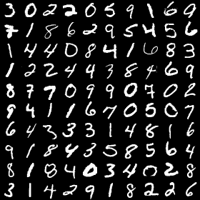

In [9]:
display_image()

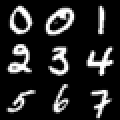

In [10]:
display_image([100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])

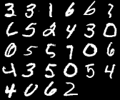

In [11]:
display_image(rand(1:4000, 28))

## 1.3 Vectorizing Logistic Regression

Since we have already used vectorized logistic regression implementation in exercise2, we can re-use the code in multi-class logistic regression. 

One thing to notice is `Optim.jl` requires user-provided gradient function `g!` to have excatly two arguments. For One-vs-all algorithm, we need to change the value matrix. Therefore we use the closure function to get cost and gradient.

In [12]:
# There are 10 classifiers in total
const NUM = 10

# Transform the images images into a standard feature matrix 
# Add a value 1 column into `images`
feature = hcat([1 for i in 1:size(images, 1)], images)

5000×401 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [13]:
# Define the logistic function, which supports both one-example-vector, or a
# training-set-matrix. x can be either a row vector or a column vector if x is
# just one training example, and this function assumes the first entry of the 
# vector is 1. If x is a training-set-matrix, then each row is one example, 
# and this function returns a n*1 matrix. If x is one-example-vector, this 
# function would return a Float rather than an array.
function h(Θ, x)
    # Single row vector
    if size(x, 1) == 1
        return 1 / (1 + e ^ -(x * Θ)[1])
    # Single column vector
    elseif size(x, 2) == 1
        return 1 / (1 + e ^ -(x' * Θ)[1])
    # Training set matrix
    else
        return result = map(z -> 1 / (1 + e ^ z), -(x * Θ))
    end
end

h (generic function with 1 method)

In [14]:
# `value` is  different for each classifier. One way to deal with it is to 
# pass `value` in a single cost() or g!() as an argument. However, `g!()` does 
# not support this method, so for the sake of consistence, we use closure here.
# The code below is modified a little bit from the ex2, now it takes `value` as
# an argument,
function cost_and_gradient(Θ, value, λ)
    m = size(feature, 1)
    return (Θ::Array) -> begin
        hypo = h(Θ, feature)
        pre = ((-value' * log(hypo) - (1 - value)' * log(1 - hypo)) / m)[1]
        return pre + ((λ / (2 * m)) * sum(Θ[2:end] .^ 2))
    end, (Θ::Array, storage::Array) -> begin
        hypo = h(Θ, feature)
        result = (feature' * (hypo - value)) / m
        storage[:] = result + (λ / m) * [0; Θ[2:end]]
    end
end

cost_and_gradient (generic function with 1 method)

## 1.4 One-vs-all Classification

Finally we can start the One-vs-all classification training process. We just implement the following:
1. Change multi-class to double-class
2. Run normal double-class logistic regression for each double-class case
3. Record the result

In [15]:
using Optim

# Construct the value vector for each classifier. value vector consists only
# 1 and 0. 1 represents it is in this classification while 0 means not.
get_value(k) = [i == k ? 1 : 0 for i in numbers]

get_value (generic function with 1 method)

In [16]:
# Start the training
# Preallocate the big matrix for all parameter Θ, where each row is a parameter
# for that classifier
Θ = Array{Float64}(NUM, size(feature, 2))

for k in 1:NUM
    # Get the local mini_θ
    cost, g! = cost_and_gradient(zeros(size(feature, 2)), get_value(k), 1)
    res = optimize(cost, g!, zeros(size(feature, 2)))
    mini_Θ = Optim.minimizer(res)
    
    # Build mini_θ into the big matrix Θ
    for col in 1:length(mini_Θ)
        Θ[k, col] = mini_Θ[col]
    end
end

Θ

10×401 Array{Float64,2}:
 -2.38369   0.0  0.0   3.53643e-5  …   0.00130431   -7.22707e-10  0.0
 -3.18303   0.0  0.0  -2.80606e-5      0.00446056   -0.000508561  0.0
 -4.79746   0.0  0.0  -8.08939e-6     -2.8706e-5    -2.47458e-7   0.0
 -2.01356   0.0  0.0  -4.02761e-6      0.000173601   3.76565e-6   0.0
  0.175505  0.0  0.0  -2.81637e-7     -0.000330084  -1.03148e-6   0.0
 -3.14857   0.0  0.0  -5.35919e-7  …  -0.00014077    1.47026e-5   0.0
 -1.90394   0.0  0.0  -1.59088e-5     -0.000527982   6.62588e-5   0.0
 -7.98717   0.0  0.0  -4.78947e-6     -8.94814e-5    7.2143e-6    0.0
 -4.57254   0.0  0.0  -5.50712e-7     -0.00133541    9.98613e-5   0.0
 -5.40575   0.0  0.0  -2.35221e-9     -0.000116628   7.88257e-6   0.0

Now we have got all parameters for each class and stored them in a matrix $\Theta$. In this problem, $\Theta \in M_{10\times 401}$. $10$ represents that we have ten classes in total ($10$ digits), and $401$ means we have $401$ features (including the constant $1$ feature).

## 1.5 One-vs-all Prediction
After getting the parameter matrix $\Theta$, prediction is trivial. We used the same method to compute the probability of each class, and choose the one having the max likelihood as our result.

In [17]:
# Multi-class prediction. Parameter x could be either a row vector (1 * 400) or
# a column vector (400 * 1).
function predict(x)
    # Compute the probabilities of each classes
    sigmoid(z) =  1 / (1 + e ^ (-z))
    xΘ = size(x, 1) == 1 ? Θ * x' : Θ * x
    proba = Array{Float64}(NUM)
    for i in 1:length(proba)
        proba[i] = sigmoid(xΘ[i])
    end
    # Return prediction
    return find(p -> p == maximum(proba), proba)[1]
end

predict (generic function with 1 method)

We then can use the following `predict_test` to test on the training sets (reload the features and compare with the correct classification).

In [18]:
# Test using result-known examples, return the correct rate. It also supports
# returning the example which classifier fails to classify with the wrong 
# class prediction.
function predict_test(feature::Array{Float64, 2}, value::Array{Float64, 2})
    correct_num = 0
    failed = Dict{Int64, Int64}()
    for t in 1:size(feature, 1)
        pred =  predict(feature[t, :])
        if  pred == value[t]
            correct_num += 1
        else
            failed[t] = pred
        end
    end
    return correct_num / size(feature, 1), failed
end

rate, failed = predict_test(feature, numbers)

(0.9446,Dict(4991=>3,1113=>8,1629=>2,1564=>2,2305=>6,4811=>3,1557=>5,1131=>9,2239=>9,2599=>4…))

The correct ratio is 0.9446. We failed to classify 277 examples and we can display what images are challenging for this algorithm.

In [19]:
failed

Dict{Int64,Int64} with 277 entries:
  4991 => 3
  1113 => 8
  1629 => 2
  1564 => 2
  2305 => 6
  4811 => 3
  1557 => 5
  1131 => 9
  2239 => 9
  2599 => 4
  2553 => 4
  1495 => 10
  1565 => 2
  2094 => 8
  4253 => 9
  1232 => 8
  4232 => 5
  3617 => 4
  4577 => 7
  4782 => 2
  4504 => 7
  3910 => 9
  3896 => 1
  1880 => 2
  2557 => 2
  ⋮    => ⋮

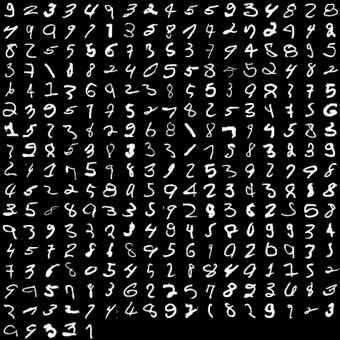

In [20]:
display_image([i for i in keys(failed)])

Some numbers seem not hard to detect, but we might need more training samples to improve the accuracy.

# 2. Neural Networks
Finally we can get into the neural network exercise. Neural network is using hidden layers to make it possible and easy to learn complex functions. While giving limited features, it can figure out the `optimal` weights for each feature in each layer. The parameters we tried to find out in linear regression become the weights in neural networks terminology.

## 2.1 Model representation
We will use matrices to represent layers and weights among layers. For notation, we use $z^{j}$ to present the $j$th layer, and $a^{j}$ for the values in $j$th layer before mapped by the activation function (we use sigmoid function in this exercise). $\Theta^{j}$ stands for the weights from layer $j$ to layer $j+1$.

In [21]:
# Import weights data
data = matread("data/ex3weights.mat")
Θ1, Θ2 = data["Theta1"], data["Theta2"]
Θ1

25×401 Array{Float64,2}:
 -0.0225624  -1.05624e-8    2.19415e-9   …  -5.04175e-6    2.80464e-9 
 -0.0983811   7.66169e-9   -9.75874e-9       2.00941e-7    3.54423e-9 
  0.116156   -8.77654e-9    8.16038e-9      -2.3367e-6    -7.50668e-9 
 -0.239693   -6.31836e-9    2.64129e-9       8.68409e-7    9.88744e-9 
 -0.731625    8.14777e-9    5.85879e-9      -2.65382e-6   -2.17661e-9 
 -0.597941   -7.76628e-9    1.07444e-8   …  -1.04026e-5   -5.65769e-10
  0.154559   -6.38022e-9   -6.05473e-9      -2.38387e-6   -6.85497e-9 
 -0.0337226   8.05171e-9    5.42028e-9       2.87857e-7    1.09306e-8 
 -0.410695    5.8812e-10    1.06828e-8      -2.36041e-7   -5.53086e-9 
  0.0234993  -8.93865e-9   -6.5513e-9        1.90242e-5   -9.8794e-9  
  0.247749   -9.7255e-9    -1.15033e-8   …   0.000106968  -1.1447e-8  
  0.265346   -4.88183e-9    8.70961e-9       6.13853e-5    7.54637e-9 
  0.0942624  -1.58218e-9   -9.52173e-9      -7.75648e-5   -1.15907e-8 
  0.202165    1.0448e-8     5.3195e-9       -1.27237

In [22]:
Θ2

10×26 Array{Float64,2}:
 -0.761004  -1.21244   -0.101871  …  -2.27193    -0.718362  -1.2969  
 -0.617852   0.615592  -1.26551       2.31181    -2.46444    1.45657 
 -0.689341  -1.94538    2.01361      -1.06138     1.02759   -0.476908
 -0.678325   0.462992   0.584923     -0.0805587  -2.03511   -1.46124 
 -0.596643  -2.04482    2.05698      -1.89613    -0.874881   2.51039 
 -0.877949   0.434411  -0.93161   …  -1.17646    -1.63463   -0.824677
 -0.527465   1.21564   -1.50096       0.0473472   1.65746    1.68541 
 -0.749015  -0.722491  -3.15228      -0.380142    0.708718  -2.11014 
 -0.666547   0.536018   1.30308      -0.223093   -1.40442   -2.13192 
 -0.460891  -1.43945   -1.2181       -0.247796    1.28009   -1.32752 

## 2.2 Feedforward Propagation and Prediction
We have already had the two weight matrices. $\Theta_1 \in M_{25 \times 401}$ since first layer has 401 features (including the bias feature) and there are 25 in the second layer (not including the bias feature because no input for bias).

- The mapping is defined as fellowing:
\begin{align*} a_1^{(2)} &= g(\Theta_{10}^{(1)}x_0 + \Theta_{11}^{(1)}x_1 + \Theta_{12}^{(1)}x_2 + \Theta_{13}^{(1)}x_3) \newline a_2^{(2)} &= g(\Theta_{20}^{(1)}x_0 + \Theta_{21}^{(1)}x_1 + \Theta_{22}^{(1)}x_2 + \Theta_{23}^{(1)}x_3) \newline a_3^{(2)} &= g(\Theta_{30}^{(1)}x_0 + \Theta_{31}^{(1)}x_1 + \Theta_{32}^{(1)}x_2 + \Theta_{33}^{(1)}x_3) \newline h_\Theta(x) &= a_1^{(3)} = g(\Theta_{10}^{(2)}a_0^{(2)} + \Theta_{11}^{(2)}a_1^{(2)} + \Theta_{12}^{(2)}a_2^{(2)} + \Theta_{13}^{(2)}a_3^{(2)}) \newline \end{align*}

- Then we can use matrix to represent the computation.
    Define $z_k^{(2)} = \Theta_{k,0}^{(1)}x_0 + \Theta_{k,1}^{(1)}x_1 + \cdots + \Theta_{k,n}^{(1)}x_n$ and $a^{(j-1)} = \begin{bmatrix}1 \\a_1^{(j-1)} \newline a_2^{(j-1)} \newline\cdots \newline a_n^{(j-1)}\end{bmatrix}$

    Then $\begin{align*}z^{(j)} = \begin{bmatrix}z_1^{(j)} \newline z_2^{(j)} \newline\cdots \newline z_n^{(j)}\end{bmatrix}\end{align*} = \Theta^{(j-1)} a^{(j-1)}$
    This computation is called **Forward Propagation**.
- We can think we are doing a logistic regression from the last hidden layer to the output. The different thing is we convert features $X$ into $a^{(j)}$.

In [23]:
# We use sigmid function as activation function
# x can be either a number or an array
function sigmoid(z)
    if size(z) == ()
        return 1 / (1 + e ^ (-z))
    else
        tem = Array{Float64}(length(z))
        for i in 1:length(z)
            tem[i] = 1 / (1 + e ^ (-z[i]))
        end
    end
    return tem
end

sigmoid (generic function with 1 method)

The output layer consists $10$ values, which are the probabilities of getting each class. Therefore we choose the max one in this layer to predict.

In [24]:
# Input layer unit x can be either a row vector or a column vector
function nn_predict(x)
    # x is the input layer, we want to get the hidden layer first
    z2 = size(x,2) == 1 ? Θ1 * x : Θ1 * x'
    a2 = sigmoid(z2)

    # Get the output layer
    # Add bias unit to a2
    unshift!(a2, 1)
    z3 = Θ2 * a2
    a3 = sigmoid(z3)
    
    return find(p -> p == maximum(a3), a3)[1]
end

nn_predict (generic function with 1 method)

In [25]:
# Test using result-known examples, return the correct rate. It also supports
# returning the example which classifier fails to classify with the wrong 
# class prediction.
function nn_predict_test(feature::Array{Float64, 2}, value::Array{Float64, 2})
    correct_num = 0
    failed = Dict{Int64, Int64}()
    for t in 1:size(feature, 1)
        pred =  nn_predict(feature[t, :])
        if  pred == value[t]
            correct_num += 1
        else
            failed[t] = pred
        end
    end
    return correct_num / size(feature, 1), failed
end

nn_rate, nn_failed = nn_predict_test(feature, numbers)

(0.9752,Dict(1971=>7,2113=>1,532=>7,4637=>3,2109=>2,638=>4,3205=>1,3665=>4,4532=>7,4991=>3…))

In [26]:
nn_failed

Dict{Int64,Int64} with 124 entries:
  1971 => 7
  2113 => 1
  532  => 7
  4637 => 3
  2109 => 2
  638  => 4
  3205 => 1
  3665 => 4
  4532 => 7
  4991 => 3
  1407 => 6
  4709 => 7
  4845 => 1
  3079 => 5
  909  => 4
  1007 => 6
  1589 => 6
  4861 => 1
  4594 => 10
  1701 => 5
  2239 => 9
  3044 => 10
  1495 => 10
  1565 => 2
  4903 => 7
  ⋮    => ⋮

The accuracy is higher than the linear regression, lets see which numbers made this neural network fail.

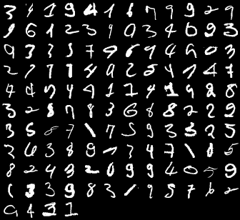

In [27]:
display_image([i for i in keys(nn_failed)])